# 1.  Introduction 

In this notebook we will discuss the rudiments of **face detection**, a popular machine learning (classification) problem you may have used in popular products like Facebook, Snapchat, or the camera app on your smart phone.  After  a brief overview of the task you will have the chance to tinker with a powerful library for performing face detection on a real dataset of images.

## 1.1  Face detection - a high level overview

Have you ever wondered how Facebook tags an image, automatically determining who is in the picture?  Or how when taking a picture of someone with your smart phone the camera automatically finds and focuses in on the person's face (so you get a clear shot)?  Apps like these depend heavily on the machine learning task known as *face detection* -  which is the task of automatically finding faces in images containing people.  

At its root face detection is a classification problem - that is a problem of distinguishing between distinct classes of things.  With face detection these distinct classes are 1) images of human faces and 2) everything else.  

One popular scheme for performing the face detection task - which we explore here - uses the linear Support Vector Machine (discussed in the nanodegree intro videos) and a popular transformation of image data (known as Histogram of Oriented Gradients).

Before going into more details lets play around with an easy to use pre-trained face detector from the wonderful [dlib library](http://dlib.net/).  This is an open source C++ library of machine learning algorithms that has Python bindings for many of its most popular tools.  This demo is based on dlib's [object detector](http://blog.dlib.net/2014/04/dlib-187-released-make-your-own-object.html), and the interested reader can dig into the full [python file here](http://dlib.net/train_object_detector.cpp.html) for further details.

## 1.2  Using dlib's pre-trained face detector

In the python cell below we load in a random image from the internet by feeding in its url.  Try out other images by copying and pasting their URL's to the *URL_to_test* variable!

In [1]:
# This cell contains a list of URL's to images on which we will perform face detection using two great algorithmss.
# Feel free to try all of the URL's listed here (links to images), or add your own and try them out!
URL_list = ['https://ab976f528c498801423d-2376439231beb5d718e8f49fe25fed31.ssl.cf1.rackcdn.com/uploads/media/media/9485/exhib_slideshow_fff_sevensamurai.jpg', 
        'http://images.huffingtonpost.com/2016-05-27-1464379108-795116-httpswww.linkedin.compulsesmallthingspeopleusejudgeyourpersonalitydrtravisbradberryHP.jpg',
        'http://cdn.collider.com/wp-content/uploads/2015/06/another-period-cast2.jpg',
        'http://cp91279.biography.com/5-Facts-About-the-Wright-Brothers_HD_768x432-16x9.jpg']

# choose a url from the list above or enter your own
URL_to_test = URL_list[2]   

In the next python cell we load in required libraries, as well as the image from the URL chosen in the previous cell.



In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import dlib                    # dlib library - for more info visit dlib.net
import glob
import urllib, cStringIO       # python libraries for opening URLs and manipulating strings
import cv2                     # opencv library for computer vision / image processing - for more info visit http://opencv.org/
from PIL import Image          # a basic library for manipulating images
import numpy as np
import os

# Now we grab the iamge from URL_to_test, load it into the notebook, and take its grayscale version.
# Somehat surprisingly many face detection algorithms (like dlib's) work very well on grayscale versions of the original color image.
file = cStringIO.StringIO(urllib.urlopen(URL_to_test).read())     # convert image from URl to numpy array for face detection
img = Image.open(file)
orig_img = img.copy()                                             # make a copy of the image for plotting purposees
img = np.asarray(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)     

In the python cell below we apply dlib's pre-trained face detector to the image we loaded in above.  After activating the cell you will see the original image (top) and same image with detections highlighted with red squares (bottom).  

Face detection done!  Plotting results.


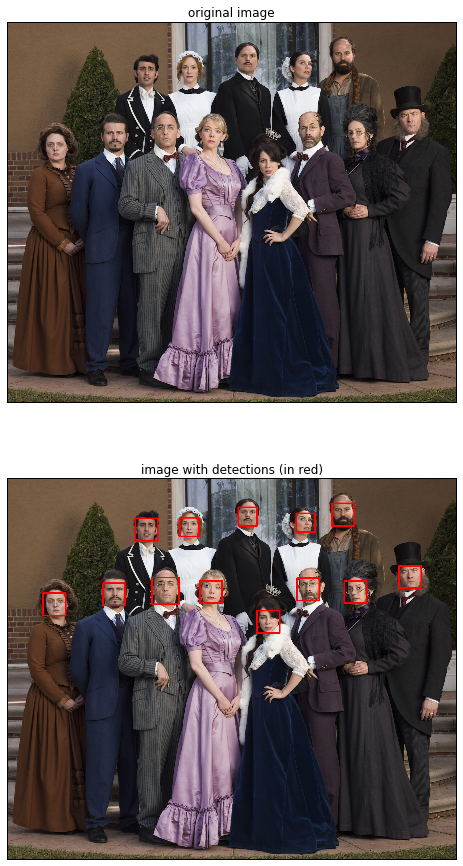

In [2]:
# Run the face detector, upsampling the image 1 time to (potentially) find smaller faces.
detector = dlib.get_frontal_face_detector()
dets = detector(gray,1)
print 'Face detection done!  Plotting results.'

# draw squares on each square-patch in which a face was detected
faces = []
for k, d in enumerate(dets):
    x = d.left()
    y = d.top()
    w = d.right() - d.left()
    h = d.top() - d.bottom()
    cv2.rectangle(img,(x,y),(x-h,y-h),(255,0,0),5)

# plot img with detected face squares in the notebook
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(211)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')
ax1.imshow(orig_img)
ax2 = fig.add_subplot(212)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('image with detections (in red)')
ax2.imshow(img)

## 1.3  A peak inside the "black box" of this face detection process

At a high level the dlib face detector you played with above is based on three concepts:

<number> 1.   The sliding window

This is often how a trained object detector is applied to a new image.  A small window is slid across the entire image, with the detector checking the content of each window for the object of interest (e.g., a face).  This process is illustrated figuratively in the image below, where every window with a detected face is outlined in green, and non-face filled in with red.

<img src="files/sliding_window.png" width=400 height=400/>

<number> 2.   The Support Vector Machine (SVM) classifier 

A linear classifier used to learn a hyperplane (as discussed in the Pico-degree intro) that separates facial and non-facial data by a hyperplane.


<number> 3.   Histogram of Oriented Gradient (HoG) features

This is a popular edge-based feature descriptor that is used for a variety of object detection and computer vision tasks, and typically provides excellent performance.  You can create a visual representation of these features trained on a small batch of facial images in the upcoming python cells.

To learn more about HoG features you can visit some of the resources listed below

The original academic paper in which HoG features were presented [Histograms of Oriented Gradients for Human Detection](https://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf)
    
For a high level overview see [Chapter 4 Section 4.6 of the textbook Machine Learning Refined](http://mlrefined.wix.com/home-page#!download-sample-chapters/cjg9)

# 2.  Training the face detector

The previous detector you used above was pre-trained - meaning that its parameters were all properly tuned on a large database of faces.  Here you yourself will train the SVM + HoG based detector in dlib on a small database of training images. This dataset, which comes with the library itself, contains 4 images with 18 faces all together.  These images have already been annotated "by hand" - that is, someone has gone to the trouble of marking each face in the images with a square (they have also marked the location of the eyes, nose, and mouth of each individual - these markings are not used for the face detection training, but for other tasks).  These faces - as well as all other patches in each of the images - constitute the dataset on which you will train the SVM classifier.

You can view these images by opening the training.xml file located at 

dlib-19.1/examples/faces/training.xml

Although this is quite small you will see that - nonetheless - you can indeed train a reasonable detector.  

Note that the content of the python cells in this Section are based on  the excellent dlib example file [train_object_detector.py](http://dlib.net/train_object_detector.py.html).  

### Training options

In the following Python cell we set several general options for training the dlib object detector.  Importantly this includes several options for artificially increasing the size of the faces portion of the dataset by taking a vertical reflection, as well as various rotations of each face in the dataset. By enhancing the training data in this way we provide the face detector a more filled out understanding of what a 'face' looks like (for example that a face need not be perfectly horizontal but can be rotated in an image).

In [ ]:
# options for the dlib object detector training module
options = dlib.simple_object_detector_training_options()
options.num_threads = 4                      # number of cores 
options.be_verbose = True
options.add_left_right_image_flips = True    # this bootstraps the face data, producing vertical flips of each face in the database
options.add_image_rotations = True           # this bootstraps the face data, producing various rotations of each face in the database

#### the choice for the parameter C
Of primary importance is the choice of the SVM parameter *C*,  called *options.C* in this dlib implementation.  This is the SVM parameter that controls how well the SVM hyperplane distinguishes between face and non-face datapoints. 

The default setting is options.C = 5, but try a handful of other values (ranging from [0 to 100]) to see if you can improve the performance of the learned model - its overall testing accuracy. 

In [ ]:
# the SVM parameter - try changing this value around to produce the lowest error on the testing set!
options.C = 5                                

After all of these options are set the detector is trained.  Afterwards several statistics (accuracy and precision) are reported on the training set as well as an independent test set.

In [3]:
# load training data and testing data paths
img_folder = 'dlib-19.1/examples/faces/'
training_xml_path = os.path.join(img_folder, "training.xml")
testing_xml_path = os.path.join(img_folder, "testing.xml")

# perform the training
dlib.train_simple_object_detector(training_xml_path, "detector.svm", options)
print 'detector training done with option.C = ' + str(options.C) + '!'

# print training and testing accuracy, precision, etc,
print("")  # Print blank line to create gap from previous output
print("Training accuracy: {}".format(
    dlib.test_simple_object_detector(training_xml_path, "detector.svm")))

print("Testing accuracy: {}".format(
    dlib.test_simple_object_detector(testing_xml_path, "detector.svm")))

detector training done with option.C = 5.0!

Training accuracy: precision: 1, recall: 0.944444, average precision: 0.944444
Testing accuracy: precision: 1, recall: 0.96, average precision: 0.96


### How well does your trained detector perform?

Having tuned options.C optimally, run the cell below (a copy of the python cell above that ran dlib's pre-trained detector) to see how well your newly trained face detector works on a new test image!

Face detection done!  Plotting results.


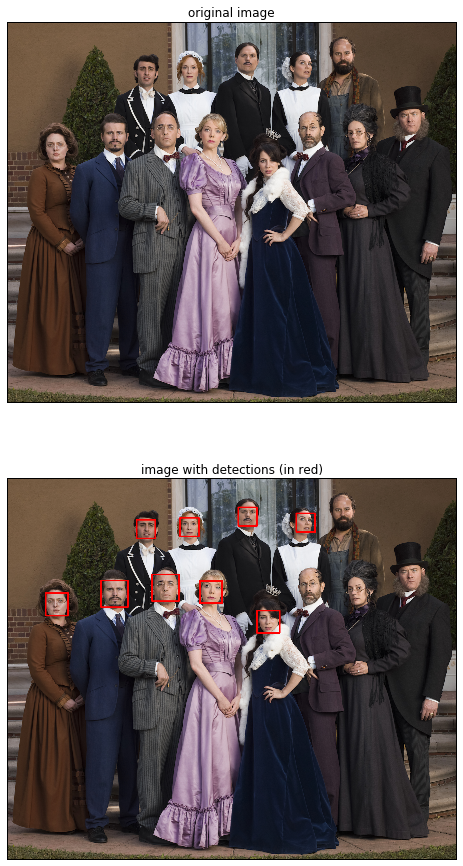

In [6]:
# make a copy of the original image (for plotting purposes) 
img = orig_img.copy()
img = np.array(img)

# load your newly trained face detector
detector = dlib.simple_object_detector("detector.svm")

# Run the face detector, upsampling the image 1 time to (potentially) find smaller faces.
dets = detector(gray,1)
print 'Face detection done!  Plotting results.'

# draw squares on each square-patch in which a face was detected
faces = []
for k, d in enumerate(dets):
    x = d.left()
    y = d.top()
    w = d.right() - d.left()
    h = d.top() - d.bottom()
    cv2.rectangle(img,(x,y),(x-h,y-h),(255,0,0),5)

# plot img with detected face squares in the notebook
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(211)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('original image')
ax1.imshow(orig_img)
ax2 = fig.add_subplot(212)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('image with detections (in red)')
ax2.imshow(img)

# Epilogue: Try training a general object detector using dlib

Faces are just one type of object one could detect in an image, but images are typically filled with many different kind of objects we might want to detect automatically.  For example, in order to operate safely self-driving vehicles must understand what sorts of objects lie in their vicinity - e.g., other cars, pedestrians, as well as road signs and markers (see [Udacity's self-driving engineer nano-degree for more info!](https://www.udacity.com/course/self-driving-car-engineer-nanodegree--nd013)).  This search for general visual objects in an image is referred to as the **object detection** problem.  

You can use the same system detailed above (used to detect faces in images) to detect any other kind of object we please.  All you need to do is swap out our original training dataset, which recall contains images of people with their faces marked by squares, with a dataset of similarly marked images containing our new object.  For more information on how to do this see the instructions in the second half of the dlib file [train_object_detector.py](http://dlib.net/train_object_detector.py.html).  